In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from glob import glob
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings

In [2]:
X_train = []
y_train = []
image_size = 224

In [3]:
folders = glob('train/*')
labels = []
def data_info():
    for i in range(len(folders)):
        labels.append(folders[i].split('\\')[-1])
    return labels
data_info()

['diseased cotton leaf',
 'diseased cotton plant',
 'fresh cotton leaf',
 'fresh cotton plant']

In [4]:
for i in labels:
    folderPath = os.path.join('train',i)
    for j in tqdm(os.listdir(folderPath), ncols = 120, desc = 'Training: '+str(i.split('/')[-1])):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)

Training: fresh cotton plant: 100%|██████████████████████████████████████████████████| 421/421 [00:02<00:00, 164.58it/s]


In [5]:
for i in labels:
    folderPath = os.path.join('test',i)
    for j in tqdm(os.listdir(folderPath), ncols = 120, desc = 'Testing: '+str(i.split('/')[-1])):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)

Testing: fresh cotton plant: 100%|████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


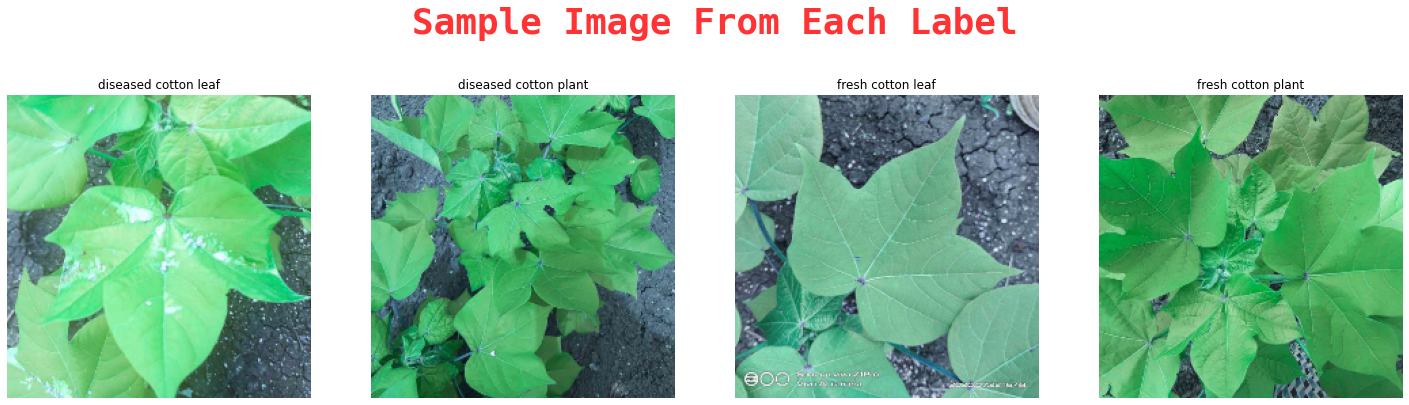

In [6]:
k=0
fig, ax = plt.subplots(1,4,figsize=(25,20))
fig.text(
    s='Sample Image From Each Label',
    size=36,fontweight='bold',
    fontname='monospace',
    color='#ff0000',
    y=0.65,
    x=0.35,
    alpha=0.8
    )
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j].split('/')[-1])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [7]:
X_train = np.array(X_train)
y_train = np.array(y_train)

In [8]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)

In [9]:
print("X_train: ", X_train.shape,'\n',"y_train: ", y_train.shape)

X_train:  (1969, 224, 224, 3) 
 y_train:  (1969,)


In [10]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

In [11]:
print('X_train-shape:', X_train.shape,'\ny_train-shape: ', y_train.shape, '\nX_tset-shape: ', X_test.shape, '\ny_test-shape: ', y_test.shape)

X_train-shape: (1772, 224, 224, 3) 
y_train-shape:  (1772,) 
X_tset-shape:  (197, 224, 224, 3) 
y_test-shape:  (197,)


In [12]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)

In [13]:
y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [14]:
mobnet = MobileNet(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

In [15]:
mobnet_model = mobnet.output
mobnet_model = tf.keras.layers.GlobalAveragePooling2D()(mobnet_model)
mobnet_model = tf.keras.layers.Dropout(rate=0.5)(mobnet_model)
mobnet_model = tf.keras.layers.Dense(4,activation='softmax')(mobnet_model)
mobnet_model = tf.keras.models.Model(inputs=mobnet.input, outputs = mobnet_model)

In [16]:
mobnet_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

                                                                 
 conv_pw_8_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_pw_8_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_dw_9 (DepthwiseConv2D)  (None, 14, 14, 512)      4608      
                                                                 
 conv_dw_9_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_dw_9_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_pw_9 (Conv2D)          (None, 14, 14, 512)       262144    
                                                                 
 conv_pw_9

In [17]:
mobnet_model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [18]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001, mode='auto',verbose=1)

In [19]:
mobnet_history = mobnet_model.fit(X_train,y_train,validation_split=0.1, epochs =20, verbose=1, batch_size=32, callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/20
50/50 [==============================] - ETA: 0s - loss: 0.3175 - accuracy: 0.9159
Epoch 1: val_accuracy improved from -inf to 0.23596, saving model to effnet.h5
50/50 [==============================] - 145s 3s/step - loss: 0.3175 - accuracy: 0.9159 - val_loss: 14.1705 - val_accuracy: 0.2360 - lr: 0.0010
Epoch 2/20
50/50 [==============================] - ETA: 0s - loss: 0.1105 - accuracy: 0.9693
Epoch 2: val_accuracy improved from 0.23596 to 0.88202, saving model to effnet.h5
50/50 [==============================] - 123s 2s/step - loss: 0.1105 - accuracy: 0.9693 - val_loss: 1.4957 - val_accuracy: 0.8820 - lr: 0.0010
Epoch 3/20
50/50 [==============================] - ETA: 0s - loss: 0.0961 - accuracy: 0.9730
Epoch 3: val_accuracy did not improve from 0.88202
50/50 [==============================] - 125s 3s/step - loss: 0.0961 - accuracy: 0.9730 - val_loss: 1.1890 - val_accuracy: 0.8708 - lr: 0.0010
Epoch 4/20
50/50 [==============================] - ETA: 0s - loss: 0.0663 -

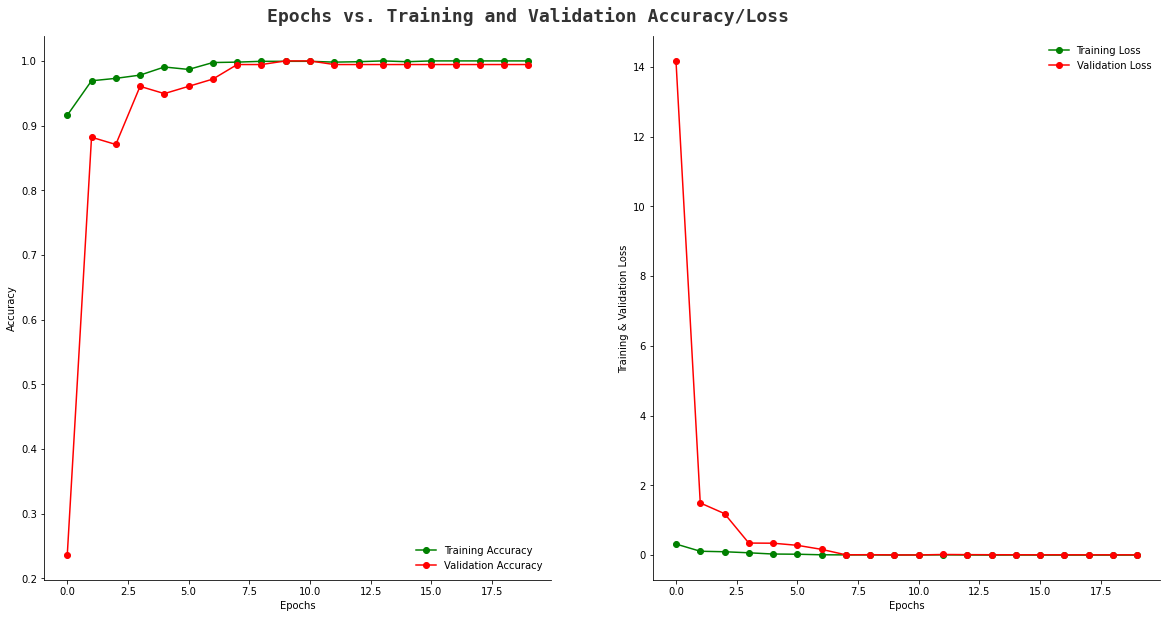

In [37]:
filterwarnings('ignore')
epochs = [i for i in range(20)]
fig, ax = plt.subplots(1,2,figsize=(20,10))
train_acc = mobnet_history.history['accuracy']
train_loss = mobnet_history.history['loss']
val_acc = mobnet_history.history['val_accuracy']
val_loss = mobnet_history.history['val_loss']
fig.text(
    s='Epochs vs. Training and Validation Accuracy/Loss',
    size=18,
    fontweight='bold',
    fontname='monospace',color='black',y=0.9,
    x=0.28,
    alpha=0.8
)
sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor='green',color='green', label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor='red',color='red', label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor='green',color='green', label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor='red',color='red', label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')
fig.show()

In [26]:
pred = mobnet_model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

7/7 [==============================] - 3s 374ms/step


In [27]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        26
           1       1.00      0.99      0.99        87
           2       1.00      1.00      1.00        46
           3       0.97      1.00      0.99        38

    accuracy                           0.99       197
   macro avg       0.99      1.00      1.00       197
weighted avg       1.00      0.99      0.99       197



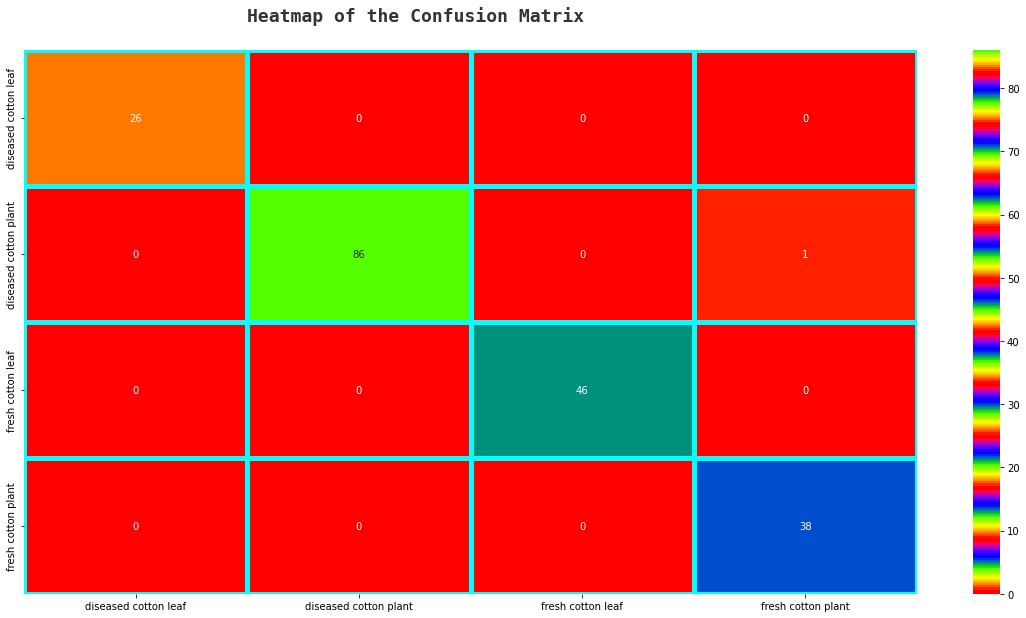

In [34]:
fig,ax=plt.subplots(1,1,figsize=(20,10))
sns.heatmap(
    confusion_matrix(y_test_new,pred),
    ax=ax,
    xticklabels=labels,
    yticklabels=labels,
    annot=True,
    cmap='prism',
    alpha=1,
    linewidths=5,
    linecolor='cyan'
)
fig.text(
    s='Heatmap of the Confusion Matrix',
    size=18,
    fontweight='bold', 
    fontname='monospace',
    color='black',
    y=0.92,
    x=0.28,
    alpha=0.8
)
plt.show()

In [36]:
A=accuracy_score(y_test_new, pred)
print("Model Accuracy is: ",np.round(A,2)*100,'%.')

Model Accuracy is:  99.0 %.
